# Stat222 HW2

Seokjun Choi

*All code blocks are Python scripts.*

## Question 1

*Python script:*
- Q1: https://github.com/letsjdosth/bnp/blob/main/hw2_q1.py
- and it depends on hw1's script: https://github.com/letsjdosth/bnp/blob/main/dp_generator.py

To begin with, let me simulate samples, with sample size $n=20, 200, 2000$.
`z_20, z_200, z_2000` are generated under $N(0,1)$,
and `y_20, y_200, y_2000` are generated under $0.5N(-2.5, 0.5^2)+0.3N(0.5,0.7^2)+0.2N(1.5,2^2)$.
I plot histograms using generated samples under the 6 cases.

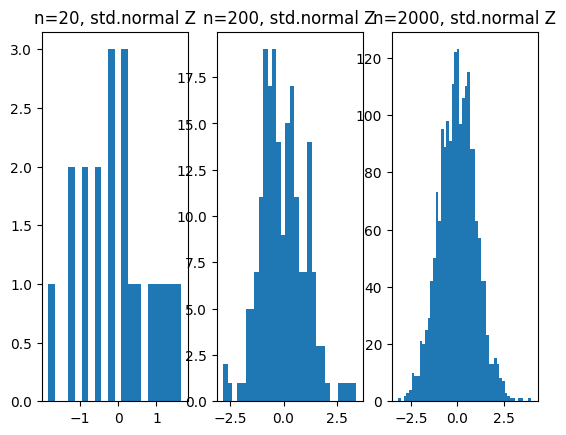

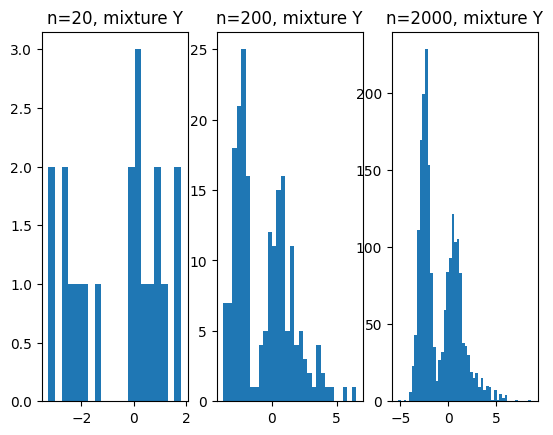

In [4]:
from random import seed, uniform, normalvariate, betavariate, randint
from functools import partial

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

from dp_generator import DirichletProcessGenerator_StickBreaking

seed(20230503)

# generate data
z_20 = [normalvariate(0, 1) for _ in range(20)]
z_200 = [normalvariate(0, 1) for _ in range(200)]
z_2000 = [normalvariate(0, 1) for _ in range(2000)]

def y_data_simulator(n_num_data):
    y_data_list = []
    for _ in range(n_num_data):
        u = uniform(0,1)
        if u<0.5:
            y_data_list.append(normalvariate(-2.5, 0.5))
        elif u<0.8:
            y_data_list.append(normalvariate(0.5, 0.7))
        else:
            y_data_list.append(normalvariate(1.5, 2))
    return y_data_list

y_20 = y_data_simulator(20)
y_200 = y_data_simulator(200)
y_2000 = y_data_simulator(2000)

fig, ax = plt.subplots(1,3)
ax[0].hist(z_20, bins=20)
ax[0].set_title("n=20, std.normal Z")
ax[1].hist(z_200, bins=30)
ax[1].set_title("n=200, std.normal Z")
ax[2].hist(z_2000, bins=50)
ax[2].set_title("n=2000, std.normal Z")
plt.show()

fig, ax = plt.subplots(1,3)
ax[0].hist(y_20, bins=20)
ax[0].set_title("n=20, mixture Y")
ax[1].hist(y_200, bins=30)
ax[1].set_title("n=200, mixture Y")
ax[2].hist(y_2000, bins=50)
ax[2].set_title("n=2000, mixture Y")
plt.show()

Next, the class `Post_DP` generates atoms and constructs CDF realization of posterior $G|data$ using the stick-breaking procedure.

In [5]:
class Post_DP(DirichletProcessGenerator_StickBreaking):
    def __init__(self, data, set_seed) -> None:
        self.y = data
        self.n = len(data)
        seed(set_seed)
        self.atom_loc = None
        self.atom_weight = None

    
    def atom_sampler(self, prior_precision:float, prior_base_measure_sampler, num_atom: int):
        #location
        atom_loc = []
        for _ in range(num_atom):
            u = uniform(0,1)
            if u < prior_precision / (prior_precision + self.n):
                atom_loc.append(prior_base_measure_sampler())
            else:
                atom_loc.append(self.y[randint(0, self.n-1)])
        
        left_stick_length = 1.0
        atom_weight = []
        for _ in range(num_atom-1):
            portion = betavariate(1, prior_precision+self.n)
            weight = portion * left_stick_length
            atom_weight.append(weight)
            left_stick_length = left_stick_length * (1 - portion)
        atom_weight.append(left_stick_length)
        return atom_loc, atom_weight

### N(0,1) case

To see the effect of prior specification and to do sensitivity analysis,
I will consider all combinations of four $G_0$ s and four $\alpha$ s.

For $G_0$,
- $N(0,1)^2$ (true)
- $N(2,1)^2$ (wrong location)
- $N(0, 0.1^2)$ (too small variance)
- $N(0, 2^2)$ (too large variance)

For $\alpha$,
- $\alpha=1$
- $\alpha=10$
- $\alpha=100$
- $\alpha=1000$

Since the base measure is continuous, let me draw realized sample paths and plot them instead of constructing confidence intervals and mean-function estimates. We can get them by binning based on cdf realization or summarizing discrete jumps over a grid, but it requires a nasty algorithm taking more computing time.
Instead, I will generate more sample paths (100 curves for each case) and plot them as translucent curves.

On the next plots, red curves are true $N(0,1)$ distribution function.
Blue translucent curves are realizations of G's posterior. A dark-blue area has more probability than a light-blue area.
The setting of $n$, $G_0$, and $\alpha$ are indicated on the title of each subplot.
From left to right, we can compare the effect of $\alpha$.
From top to bottom, we can compare the effect of $G_0$.
For each set of subplots, we can see the effect of $n$.

In [6]:
std_norm_sampler = partial(sp.stats.norm.rvs, loc=0, scale=1)
std_norm_cdf = partial(sp.stats.norm.cdf, loc=0, scale=1)
def mixture_cdf(x):
    return 0.5*sp.stats.norm.cdf(x, loc=-2.5, scale=0.5) + 0.3*sp.stats.norm.cdf(x, loc=0.5, scale=0.7) + 0.2*sp.stats.norm.cdf(x, loc=1.5, scale=2)

#prior settings
prior_G0 = [partial(sp.stats.norm.rvs, loc=0, scale=1),
            partial(sp.stats.norm.rvs, loc=2, scale=1),
            partial(sp.stats.norm.rvs, loc=0, scale=0.1),
            partial(sp.stats.norm.rvs, loc=0, scale=2)]
prior_G0_str = [r"N(0,1)",r"N(2,1)",r"N(0,$0.1^2$)",r"N(0,$2^2$)"]
prior_alpha = [1, 10, 100, 1000]

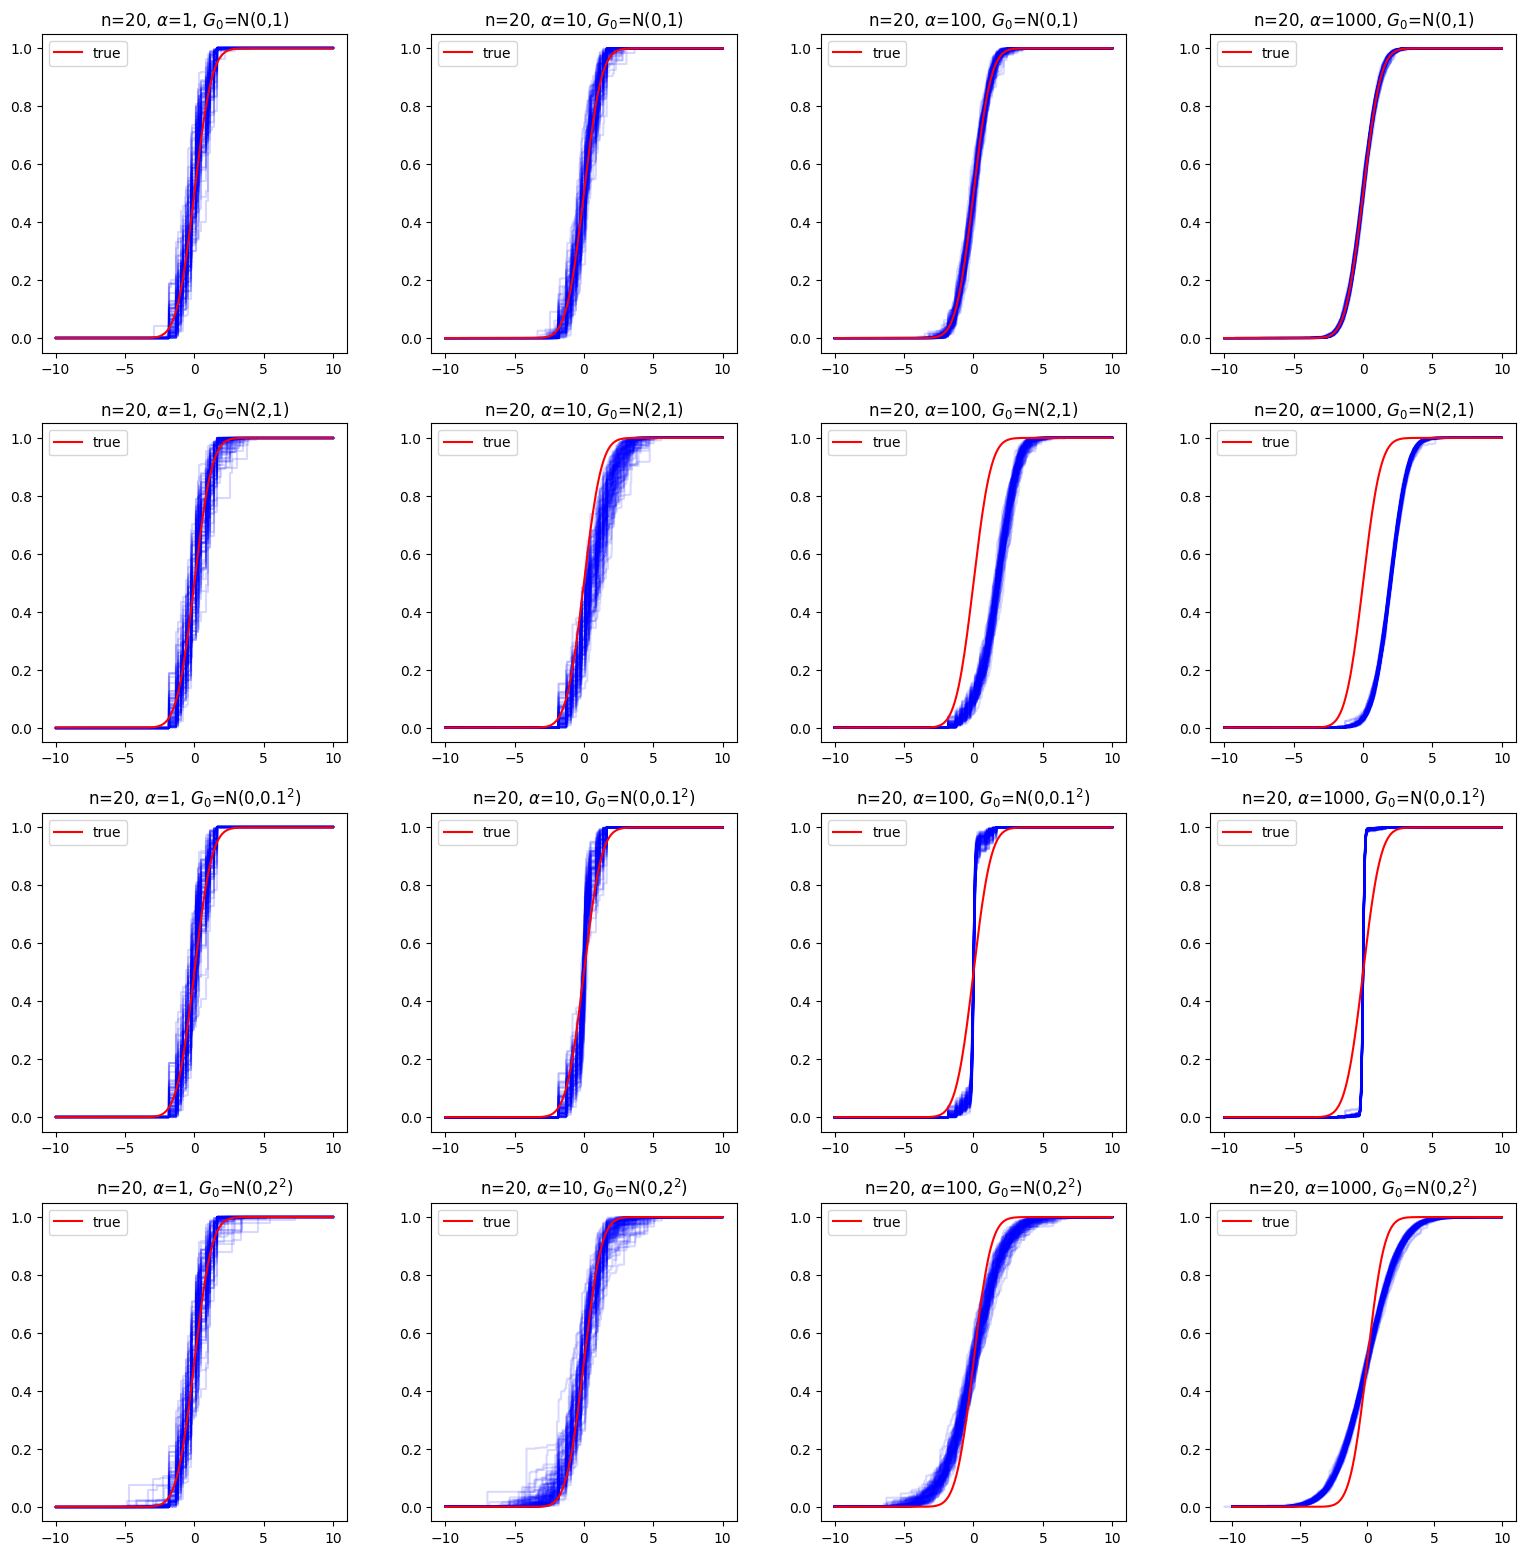

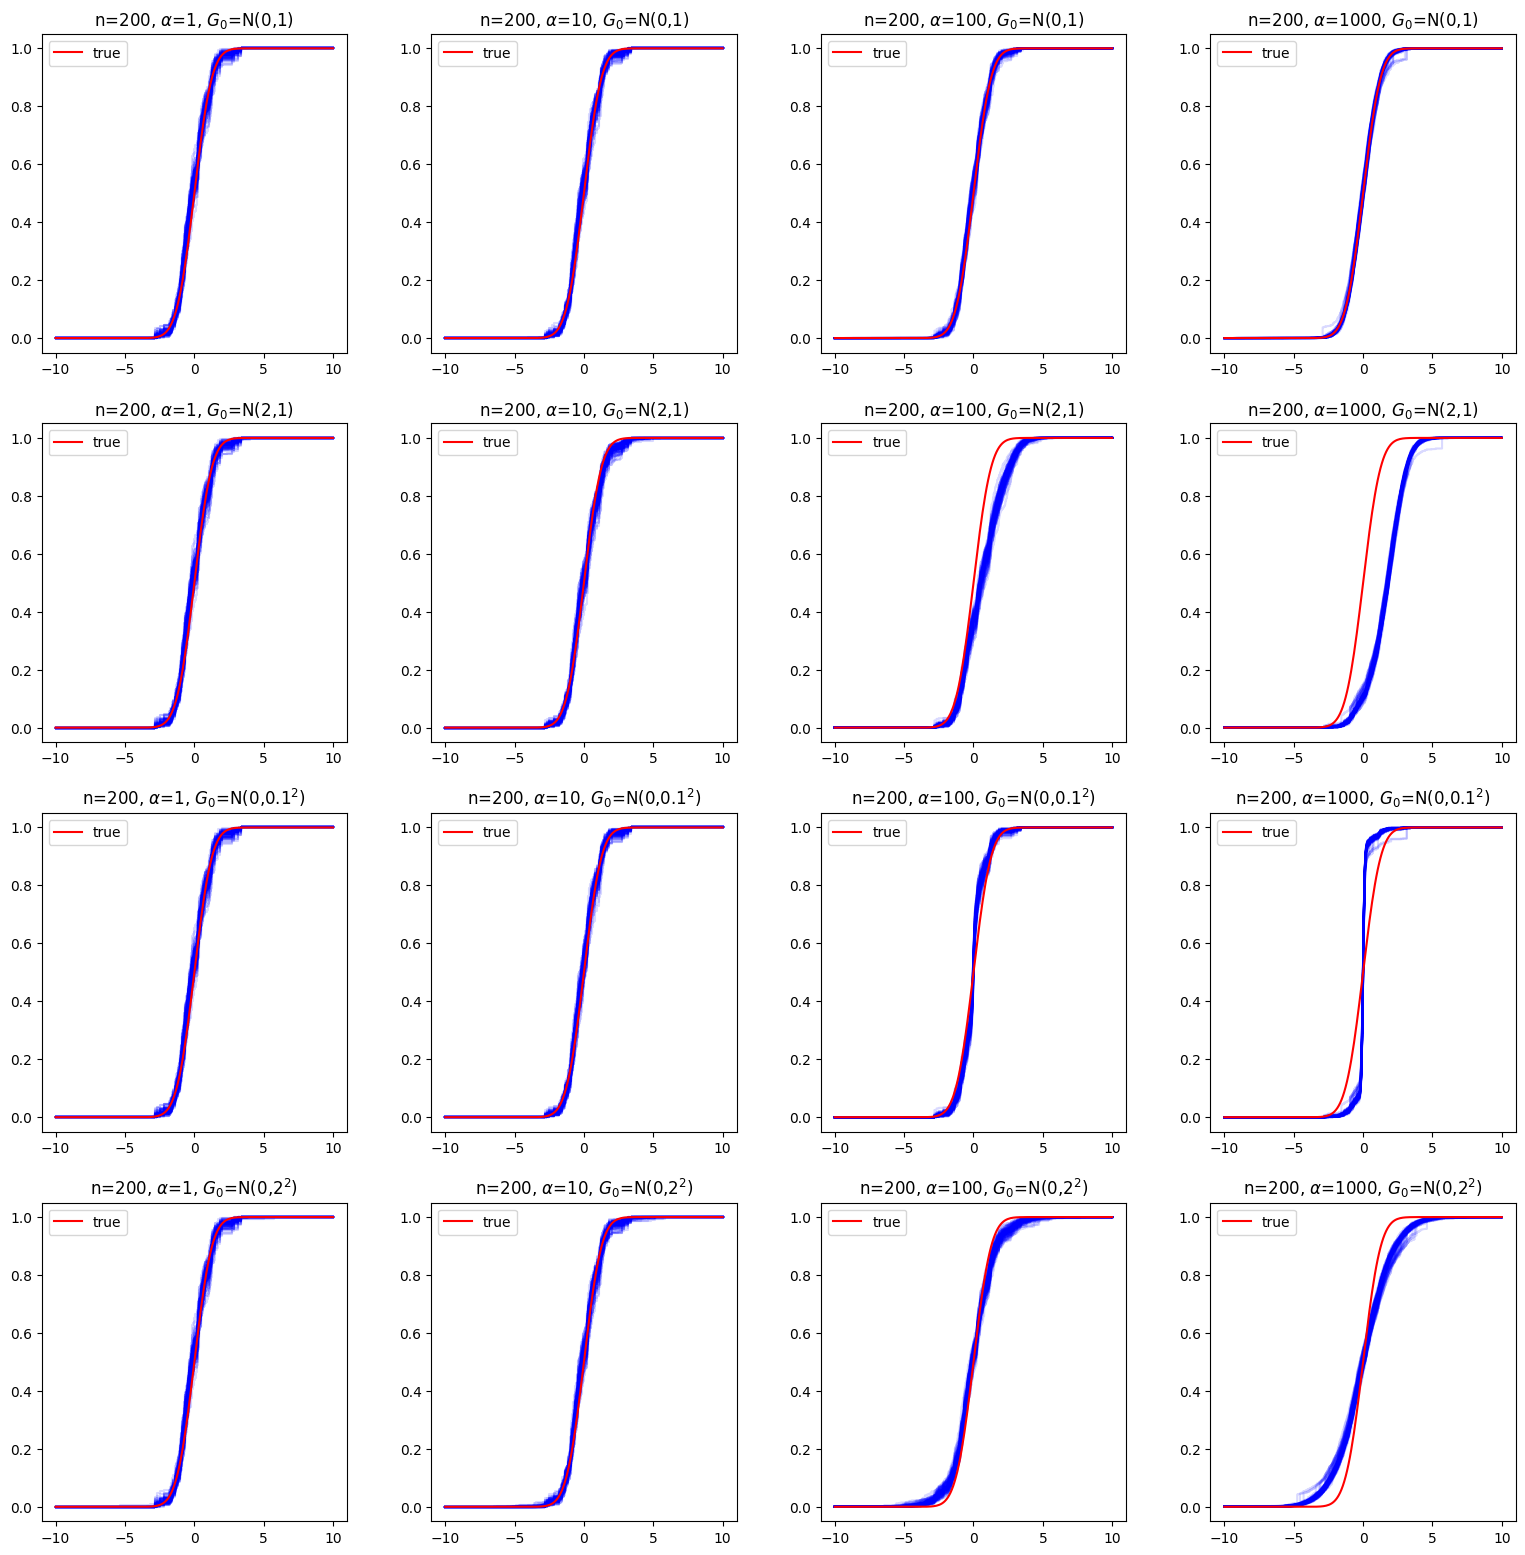

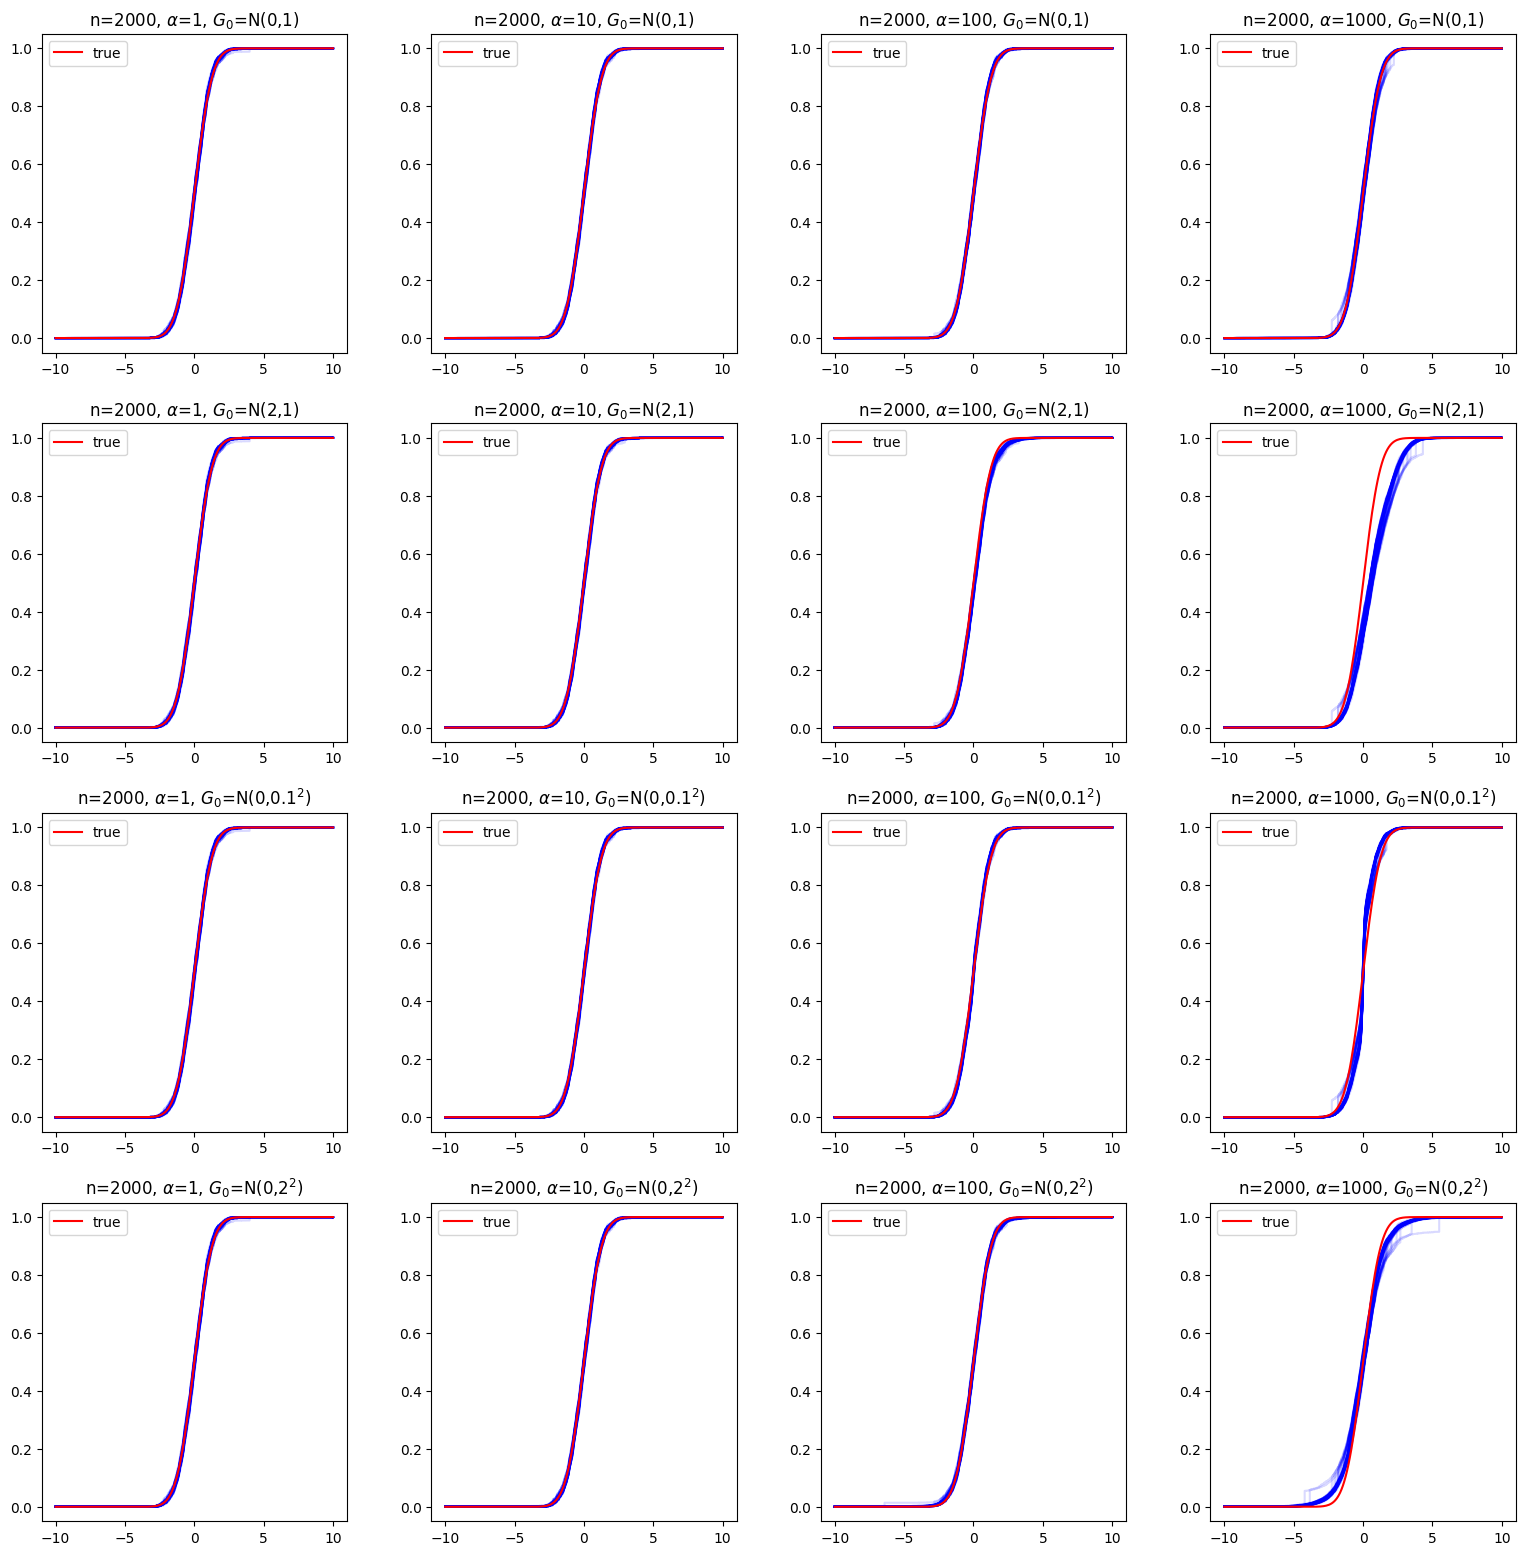

In [7]:
fig, axs = plt.subplots(len(prior_G0), len(prior_alpha), figsize=(len(prior_alpha)*4, len(prior_G0)*4))
fig.tight_layout(pad=3, w_pad=3, h_pad=3)
for g_idx, (g0, g0_str) in enumerate(zip(prior_G0, prior_G0_str)):
    for a_idx, alpha in enumerate(prior_alpha):
        for i in range(100):
            fit_inst = Post_DP(z_20, 20230503+i)
            atom_loc, atom_weight = fit_inst.atom_sampler(alpha, g0, 4000)
            grid, increments, sample_path = fit_inst.cumulatative_dist_func(atom_loc, atom_weight, -10, 10)
            axs[g_idx, a_idx].step(grid, sample_path, where='post', c='blue', alpha=0.15)
        axs[g_idx, a_idx].plot(np.linspace(-10, 10, 200), std_norm_cdf(np.linspace(-10, 10, 200)), c='red', label=r'true')
        axs[g_idx, a_idx].legend()
        axs[g_idx, a_idx].set_title("n=20, "+ r'$\alpha$='+str(alpha)+r', $G_0$='+g0_str, fontsize=12)
plt.show()

fig, axs = plt.subplots(len(prior_G0), len(prior_alpha), figsize=(len(prior_alpha)*4, len(prior_G0)*4))
fig.tight_layout(pad=3, w_pad=3, h_pad=3)
for g_idx, (g0, g0_str) in enumerate(zip(prior_G0, prior_G0_str)):
    for a_idx, alpha in enumerate(prior_alpha):
        for i in range(100):
            fit_inst = Post_DP(z_200, 20230503+i)
            atom_loc, atom_weight = fit_inst.atom_sampler(alpha, g0, 4000)
            grid, increments, sample_path = fit_inst.cumulatative_dist_func(atom_loc, atom_weight, -10, 10)
            axs[g_idx, a_idx].step(grid, sample_path, where='post', c='blue', alpha=0.15)
        axs[g_idx, a_idx].plot(np.linspace(-10, 10, 200), std_norm_cdf(np.linspace(-10, 10, 200)), c='red', label=r'true')
        axs[g_idx, a_idx].legend()
        axs[g_idx, a_idx].set_title("n=200, "+r'$\alpha$='+str(alpha)+r', $G_0$='+g0_str)
plt.show()

fig, axs = plt.subplots(len(prior_G0), len(prior_alpha), figsize=(len(prior_alpha)*4, len(prior_G0)*4))
fig.tight_layout(pad=3, w_pad=3, h_pad=3)
for g_idx, (g0, g0_str) in enumerate(zip(prior_G0, prior_G0_str)):
    for a_idx, alpha in enumerate(prior_alpha):
        for i in range(100):
            fit_inst = Post_DP(z_2000, 20230503+i)
            atom_loc, atom_weight = fit_inst.atom_sampler(alpha, g0, 9000)
            grid, increments, sample_path = fit_inst.cumulatative_dist_func(atom_loc, atom_weight, -10, 10)
            axs[g_idx, a_idx].step(grid, sample_path, where='post', c='blue', alpha=0.15)
        axs[g_idx, a_idx].plot(np.linspace(-10, 10, 200), std_norm_cdf(np.linspace(-10, 10, 200)), c='red', label=r'true')
        axs[g_idx, a_idx].legend()
        axs[g_idx, a_idx].set_title("n=2000, "+r'$\alpha$='+str(alpha)+r', $G_0$='+g0_str, fontsize=12)
plt.show()

Let me comment on a few things that we can observe.

- $\alpha$ has a crucial role. It controls continuity and precision at the same time. Moreover, it represents how powerful the prior is in the unit of sample size. If $\alpha$ is relatively much higher than $n$, the posterior mass highly concentrates on $G_0$ with high continuity and becomes very hard to dominate by data. Thus, when $\alpha$ is high and $n$ is low, specifying a good $G_0$ (close to true DGP) becomes very important. We can get false results in the same way that $G_0$ is wrong with true G.
- If we fix $n$, we cannot avoid a trade-off between conitnuity with high $\alpha$ and risk of mis-specification of $G_0$.
- A large data size $n$ can remedy many problems of DP models. It relieves the discreteness of realization as well as misspecification of $G_0$. But my skeptical view says that the required $n$ can be very large (even more than parametric models) to satisfy a pre-specified criterion. For example, we can see that cases $n=2000$ and $\alpha=2000$ under a wrong $G_0$ do not seem very good.
- But large $n$ makes us pay a cost by the long posterior computing time. It requires a very long stick-breaking procedure as $n$ large.

To sum up, if $n$ is small and $\alpha$ is large, prior $G_0$ is very important.
If we have enough evidence on $G_0$, setting large $\alpha$ helps yield a satisfactory result.
However, if we want to rely on data more, setting $\alpha$ small is better.
We need less concern about the prior as $n$ grows and $\alpha$ gets relatively smaller than $n$.

### Mixture case: $0.5N(-2.5, 0.5^2)+0.3N(0.5,0.7^2)+0.2N(1.5,2^2)$

I will repeat the above procedure with the dataset generated by the mixture. I will consider the same settings of $G_0$ and $\alpha$ as the above.
Note that all $G_0$ are wrong now.

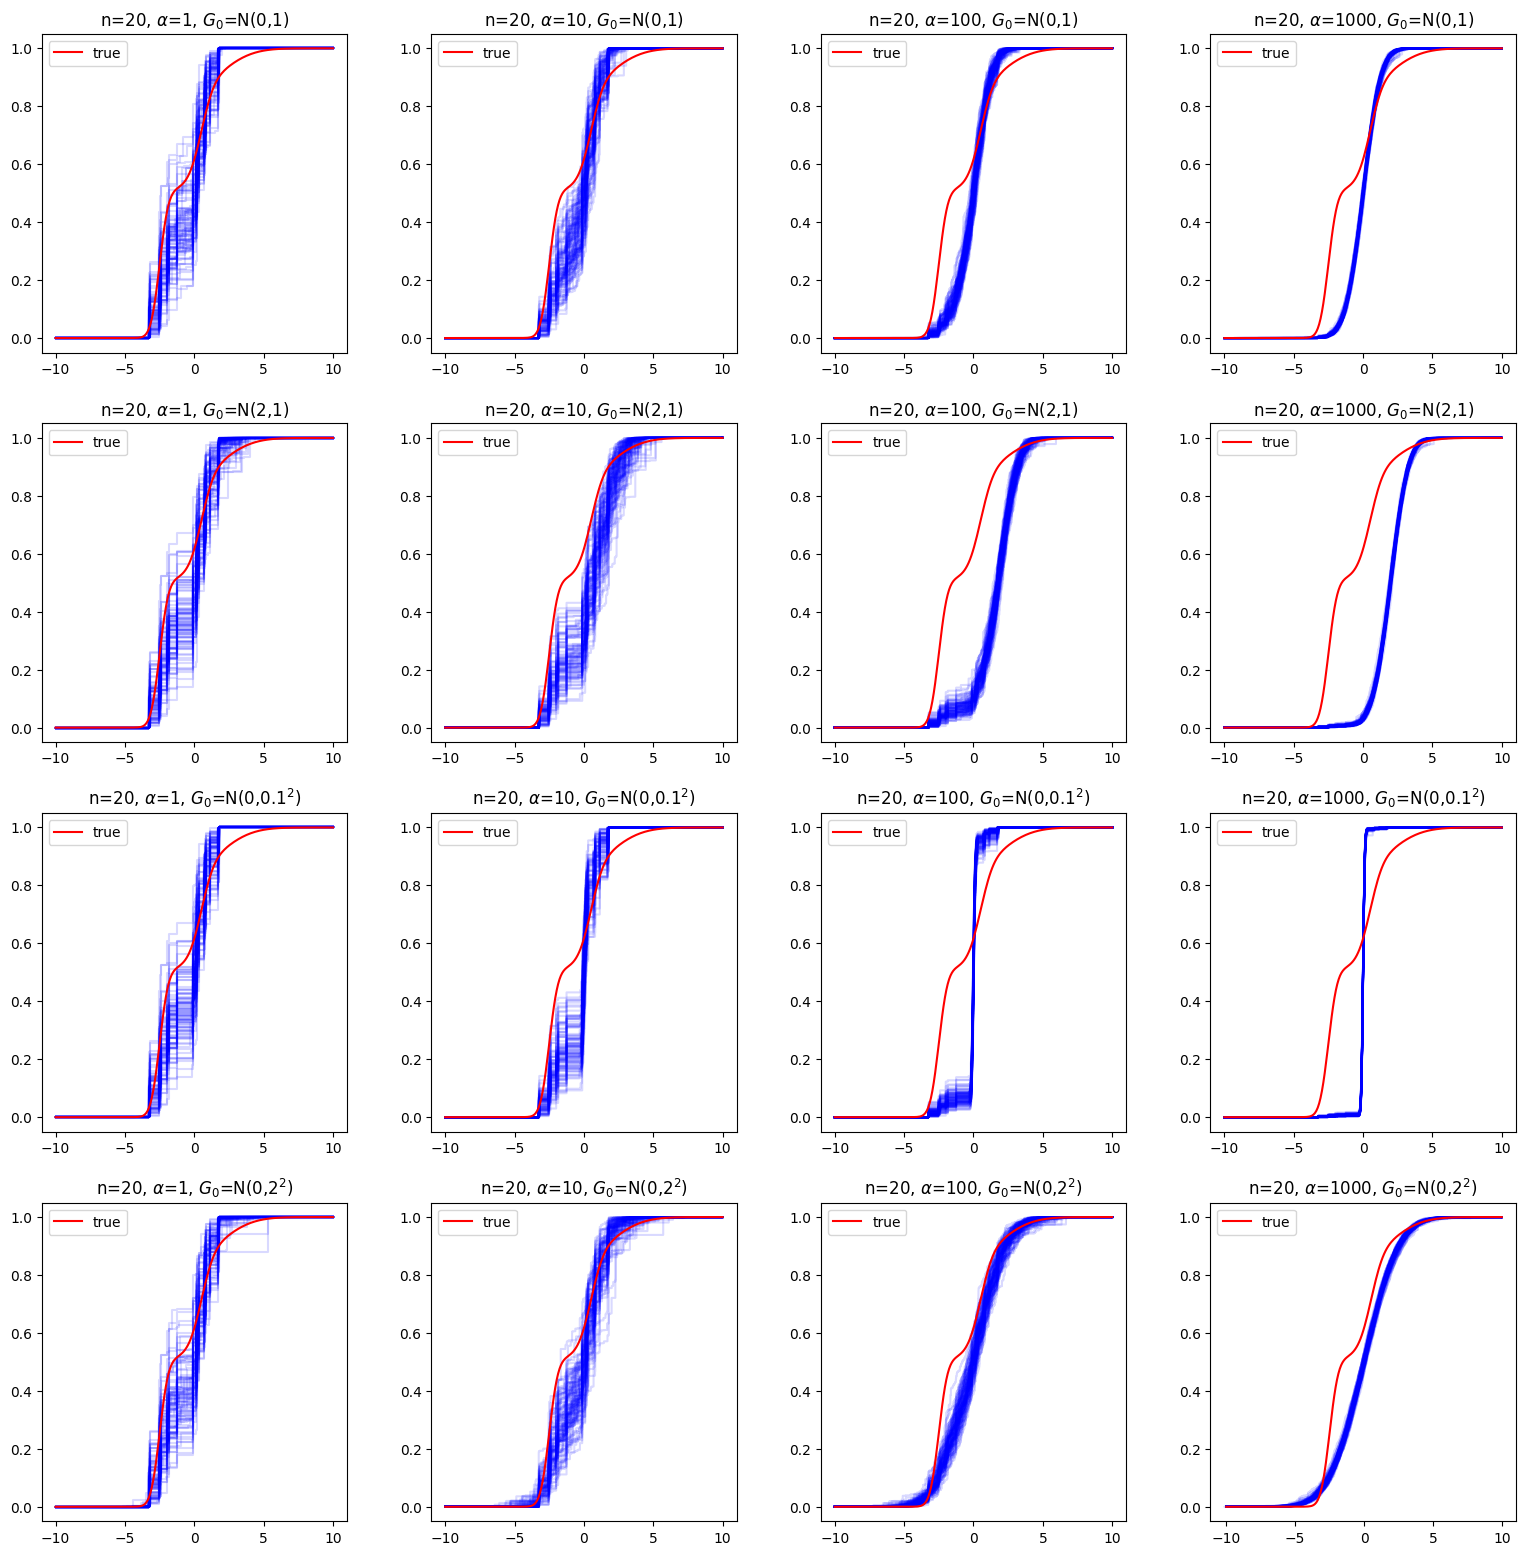

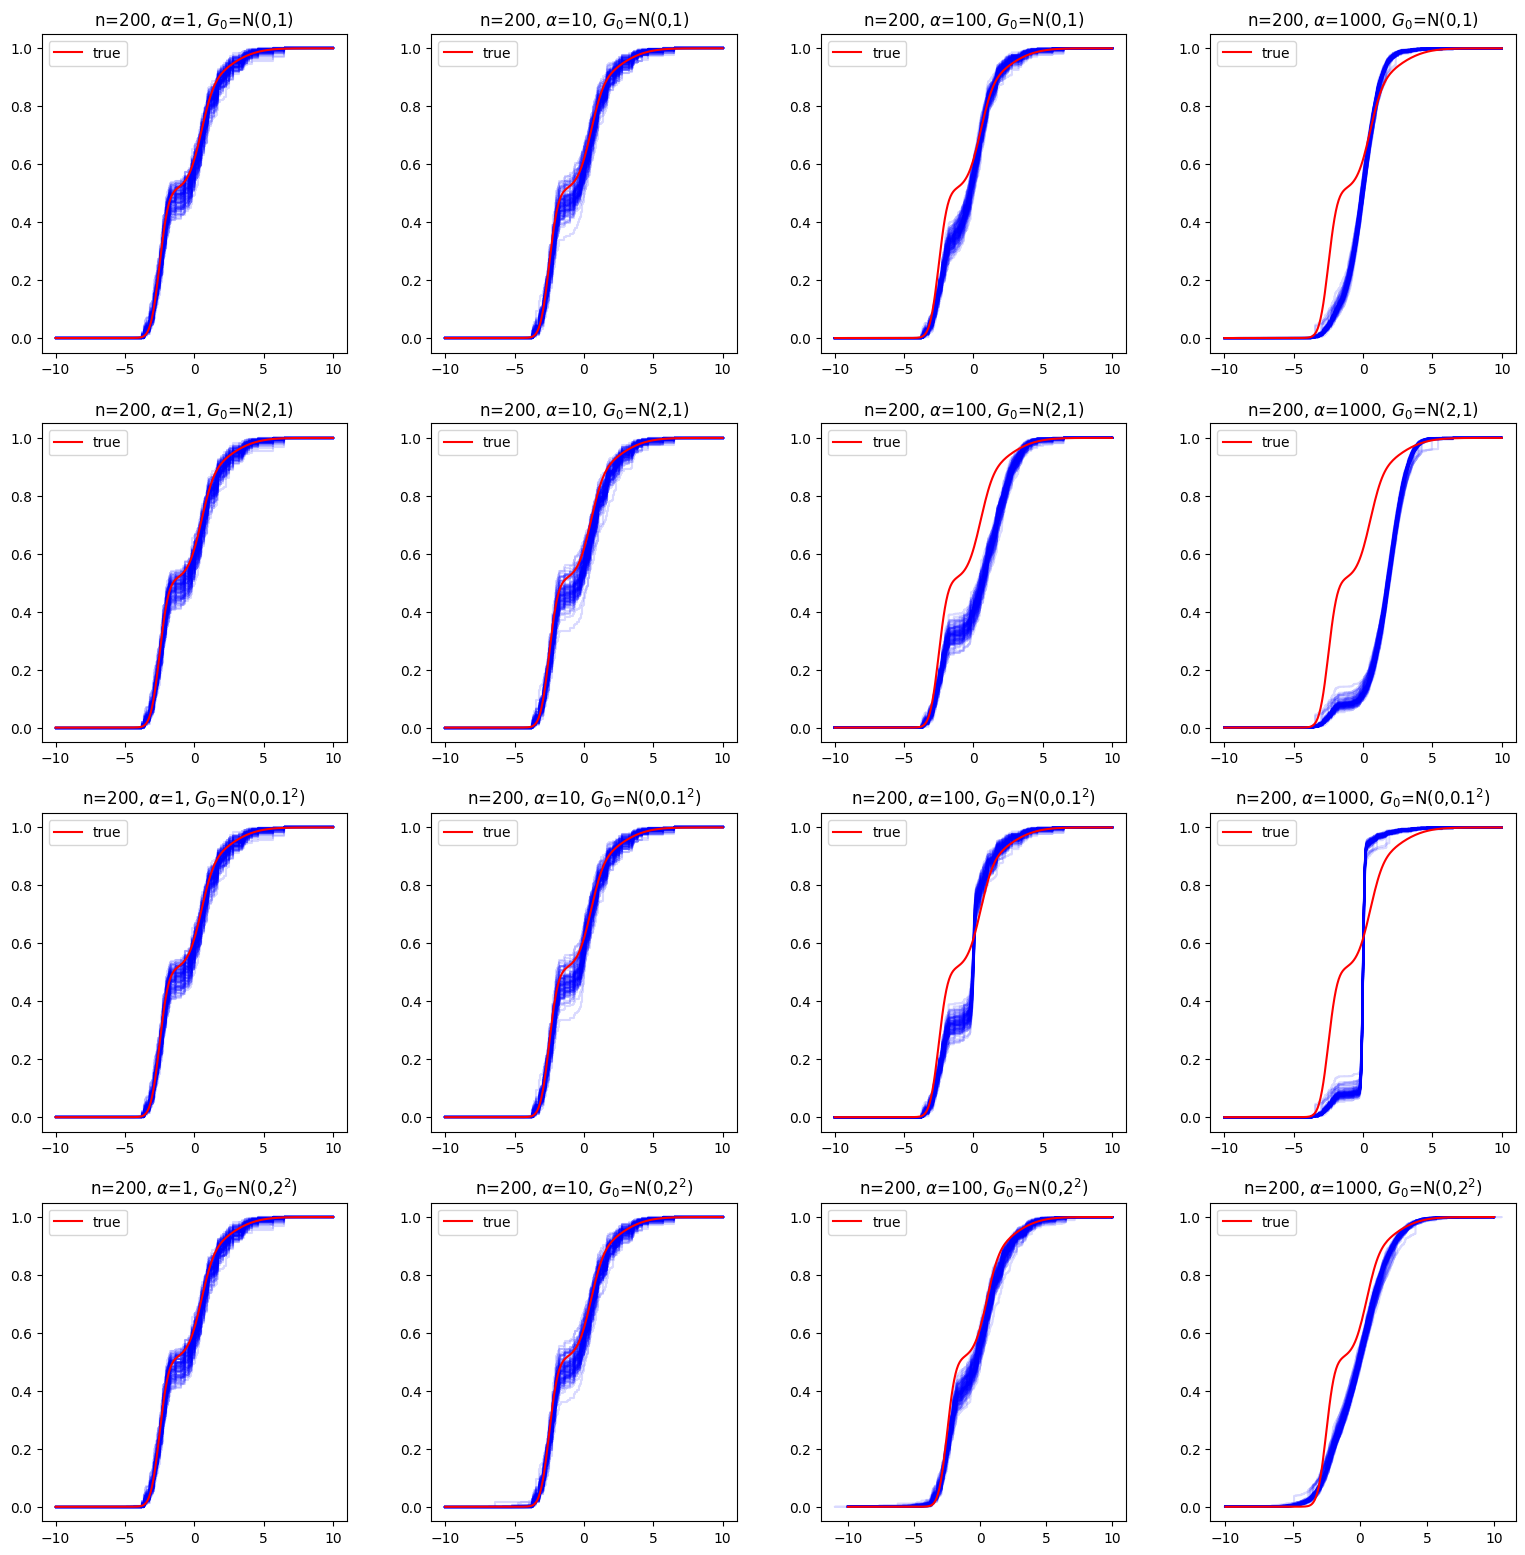

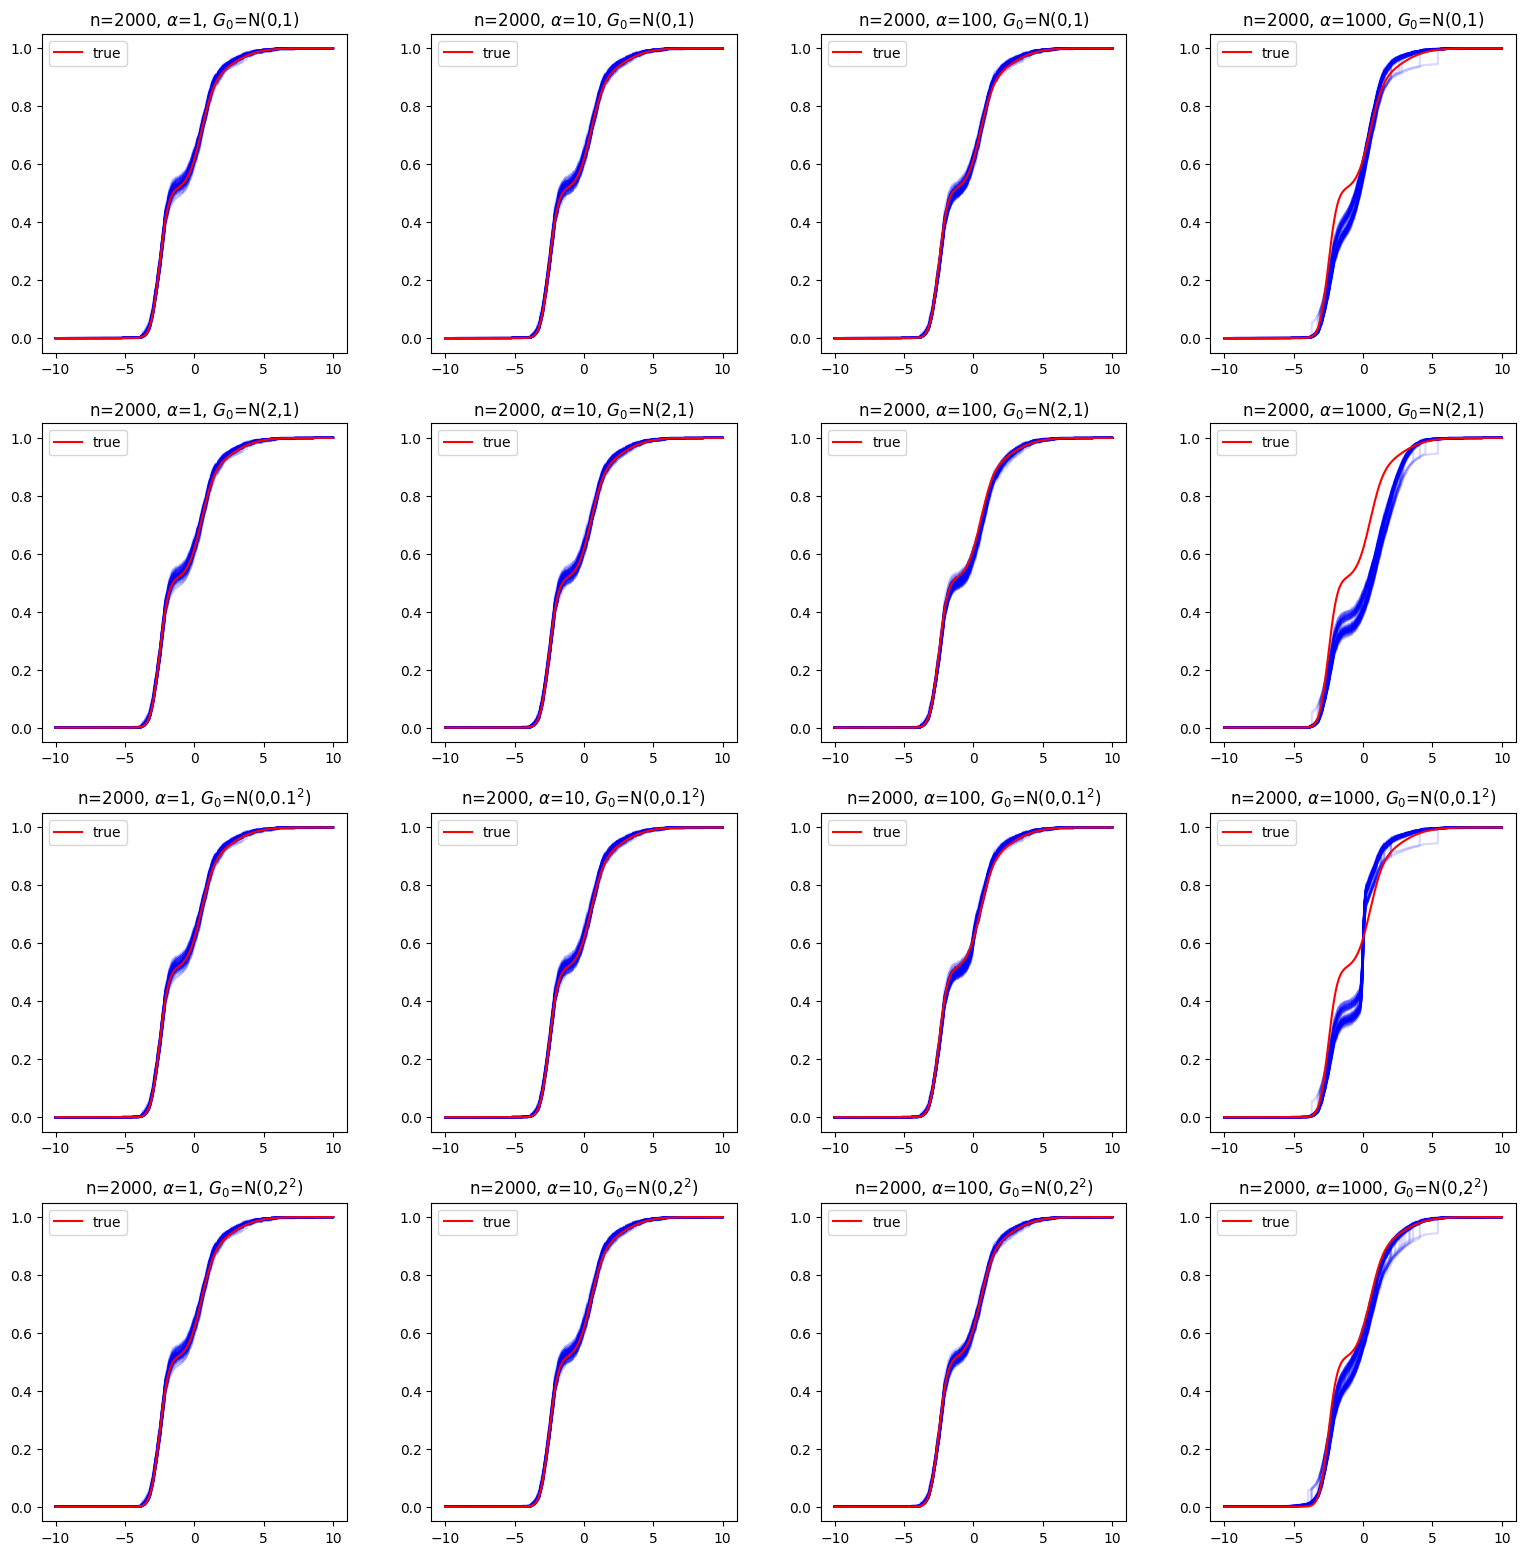

In [8]:
fig, axs = plt.subplots(len(prior_G0), len(prior_alpha), figsize=(len(prior_alpha)*4, len(prior_G0)*4))
fig.tight_layout(pad=3, w_pad=3, h_pad=3)
for g_idx, (g0, g0_str) in enumerate(zip(prior_G0, prior_G0_str)):
    for a_idx, alpha in enumerate(prior_alpha):
        for i in range(100):
            fit_inst = Post_DP(y_20, 20230503+i)
            atom_loc, atom_weight = fit_inst.atom_sampler(alpha, g0, 4000)
            grid, increments, sample_path = fit_inst.cumulatative_dist_func(atom_loc, atom_weight, -10, 10)
            axs[g_idx, a_idx].step(grid, sample_path, where='post', c='blue', alpha=0.15)
        axs[g_idx, a_idx].plot(np.linspace(-10, 10, 200), mixture_cdf(np.linspace(-10, 10, 200)), c='red', label=r'true')
        axs[g_idx, a_idx].legend()
        axs[g_idx, a_idx].set_title("n=20, "+r'$\alpha$='+str(alpha)+r', $G_0$='+g0_str, fontsize=12)
plt.show()

fig, axs = plt.subplots(len(prior_G0), len(prior_alpha), figsize=(len(prior_alpha)*4, len(prior_G0)*4))
fig.tight_layout(pad=3, w_pad=3, h_pad=3)
for g_idx, (g0, g0_str) in enumerate(zip(prior_G0, prior_G0_str)):
    for a_idx, alpha in enumerate(prior_alpha):
        for i in range(100):
            fit_inst = Post_DP(y_200, 20230503+i)
            atom_loc, atom_weight = fit_inst.atom_sampler(alpha, g0, 4000)
            grid, increments, sample_path = fit_inst.cumulatative_dist_func(atom_loc, atom_weight, -10, 10)
            axs[g_idx, a_idx].step(grid, sample_path, where='post', c='blue', alpha=0.15)
        axs[g_idx, a_idx].plot(np.linspace(-10, 10, 200), mixture_cdf(np.linspace(-10, 10, 200)), c='red', label=r'true')
        axs[g_idx, a_idx].legend()
        axs[g_idx, a_idx].set_title("n=200, "+r'$\alpha$='+str(alpha)+r', $G_0$='+g0_str, fontsize=12)
plt.show()

fig, axs = plt.subplots(len(prior_G0), len(prior_alpha), figsize=(len(prior_alpha)*4, len(prior_G0)*4))
fig.tight_layout(pad=3, w_pad=3, h_pad=3)
for g_idx, (g0, g0_str) in enumerate(zip(prior_G0, prior_G0_str)):
    for a_idx, alpha in enumerate(prior_alpha):
        for i in range(100):
            fit_inst = Post_DP(y_2000, 20230503+i)
            atom_loc, atom_weight = fit_inst.atom_sampler(alpha, g0, 9000)
            grid, increments, sample_path = fit_inst.cumulatative_dist_func(atom_loc, atom_weight, -10, 10)
            axs[g_idx, a_idx].step(grid, sample_path, where='post', c='blue', alpha=0.15)
        axs[g_idx, a_idx].plot(np.linspace(-10, 10, 200), mixture_cdf(np.linspace(-10, 10, 200)), c='red', label=r'true')
        axs[g_idx, a_idx].legend()
        axs[g_idx, a_idx].set_title("n=2000, "+r'$\alpha$='+str(alpha)+r', $G_0$='+g0_str, fontsize=12)
plt.show()

We can make similar comments as the N(0,1) case.
We cannot get smooth and well-approximated realization simultaneously under the small and fixed $n$, because of $\alpha$'s multiple roles.
Large $n$ relieves the trade-off, but it still seems insufficient even at $n=2000$ and $\alpha=1000$.

*One sentence summary(?): Bayesian nonparametric DP models love large samples!*